In [ ]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

## Tính thủ công US AQI

Chắc không cần đâu tại có sẵn cột này trong dataset, mà tôi thấy tính được từ pollutant nên thử xem để sau có predict nồng độ pollutant thì cũng tự tính ra được AQI. [SOURCE](https://aqihub.info/indices/us)

$ \displaystyle AQI_P = \frac{I_{\text{high}} - I_{\text{low}}}{BP_{\text{high}} - BP_{\text{low}}} \times (C_P - BP_{\text{low}}) + I_{\text{low}} $

- $C_P$: nồng độ chất $P$
- $BP_{\text{high}}, BP_{\text{low}}$: breakpoint (cutoff) trên/dưới của category mà nồng độ trên rơi vào (xem bảng)
- $I_{\text{high}}, I_{\text{low}}$: breakpoint trên/dưới của AQI tương ứng với category trên

<img src="https://gcdnb.pbrd.co/images/yeNPAMPnGnmH.png?o=1" alt="" width="1500"/>

Ví dụ nồng độ của PM2.5 ($C_P$) là 40μg/m³, thì $BP$ thấp 35.5 cao 55.4, và $I$ thấp 101 cao 150.

Công thức trên thường dùng để tính daily AQI (24h aggregattion, hoặc tính hourly AQI dùng rolling mean), nhưng cũng không có tính cảnh báo lắm tại có xu hướng smooth out spikes (VD: cháy rừng thì AQI tính ra cũng k tăng lên nhiều hoặc tăng nhưng chưa hiện ngay).

Nên mới có công thức **NowCast** dùng cho hourly AQI calculation. Với PM2.5, NowCast sẽ tính 12h weighted rolling mean cho nồng độ, những giờ gần hơn sẽ có weight lớn hơn. Tính nồng độ trung bình xong lại ném vào công thức trên.

- Scaled Rate of Change (SRoC) tính bằng $\displaystyle \text{SRoC} = \frac{M_{max} - M_{min}}{M_{max}}$, $M_{max} và M_{min}$ là max và min concentration trong 12h.
- Weight factor $\text{WF}$ nằm trong khoảng $[0.5,1]$, tính bằng $\displaystyle \text{WF} = \text{Max}(1 - \text{SRoC}, 0.5)$
- Concentration trong 12h tính bằng $\displaystyle C = \frac{\sum_{i=1}^{12} (C_i \times \text{WF}^{i-1})}{\sum_{i=1}^{12} C_i}$, $C_{1}$ là concentration của giờ gần nhất và $C_{12}$ là xa nhất.

In [2]:
df = pd.read_csv('data/hanoi_air_weather_merged.csv')
print(df.columns)

Index(['time', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'rain', 'wind_direction_10m', 'wind_speed_10m', 'pm25', 'pm10', 'co',
       'no2', 'so2', 'o3', 'european_aqi', 'european_aqi_pm25', 'us_aqi',
       'us_aqi_pm25'],
      dtype='object')


In [3]:
print(df['pm25'][:20])

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7     40.3
8     30.0
9     32.7
10    34.9
11    38.3
12    41.1
13    43.5
14    46.6
15    45.1
16    44.0
17    47.5
18    51.0
19    62.6
Name: pm25, dtype: float64


In [4]:
# ??? k hiểu sao mấy dòng đầu lại chưa có pm25, thôi thì xem từ sau có missing dòng nào k vì weighted mean nên mất 1-2h gần nhất sẽ skew cái nowcast conc cực mạnh
mask = df.loc[7:, 'pm25'].isna()
print("Missing count:", int(mask.sum()))
print("Missing indices:", df.loc[7:, 'pm25'][mask].index.tolist())

Missing count: 0
Missing indices: []


In [6]:
# Overall AQI = Max AQIp. Xem có Overall AQI nào không phải của PM2.5 nào...
mask = df['us_aqi'].notna() & df['us_aqi_pm25'].notna()
count = int(np.isclose(df.loc[mask, 'us_aqi'], df.loc[mask, 'us_aqi_pm25']).sum())
print(f'{mask.size} rows with AQI, {count} rows where Overall AQI == PM2.5 AQI')

28896 rows with AQI, 26572 rows where Overall AQI == PM2.5 AQI


Đa phần Overall AQI chính là của PM2.5, đề thầy cho cũng là forecast/nowcast PM2.5. Chắc mình cứ làm/tính từ PM2.5 conc thôi nhỉ còn mấy pollutant khác dùng để học thôi.

Mấy cái European tôi vứt đi nhé, tại đa phần các quốc gia dùng US AQI với cả US AQI cảnh báo sớm hơn (nồng độ pollutant đến mức cảnh báo thấp hơn). Thêm cái tính thủ công AQI theo tiêu chuẩn EU hơi oằn tà là vằn :))))

In [ ]:
# Functions: get_aqi_category, calc_piecewise, calc_nowcast_conc
def get_aqi_category(aqi):
    """Returns the textual category for a given AQI value (US Standard)."""
    if aqi is None or np.isnan(aqi):
        return None
    
    val = int(aqi)
    if val <= 50: return "Good"
    if val <= 100: return "Moderate"
    if val <= 150: return "Unhealthy for Sensitive Groups"
    if val <= 200: return "Unhealthy"
    if val <= 300: return "Very Unhealthy"
    return "Hazardous"


def calc_piecewise(conc, breakpoints):
    """Helper to find the bucket and calculate linear interpolation."""
    if pd.isna(conc) or conc < 0:
        return np.nan
        
    for (bp_low, bp_high, i_low, i_high) in breakpoints:
        if bp_low <= conc <= bp_high:
            return round(((i_high - i_low) / (bp_high - bp_low)) * (conc - bp_low) + i_low)
            
    # Handle extrapolation for "Hazardous" levels
    last_bp = breakpoints[-1]
    if conc > last_bp[1]:
        slope = (last_bp[3] - last_bp[2]) / (last_bp[1] - last_bp[0])
        return round(slope * (conc - last_bp[1]) + last_bp[3])
    
    return np.nan


def calc_nowcast_conc(series):
    """
    Calculates the US EPA NowCast concentration for a single window of data.
    This function is intended to be used with pandas rolling().apply().
    
    Args:
        series (pd.Series or np.array): 12 hours of PM2.5 data.
                                        Last element is the current hour.
    """
    data = np.array(series)
    
    c_max = np.max(data)
    c_min = np.min(data)
    w = max(1 - (c_max-c_min) / c_max, 0.5)
        
    # Calculate the weighted average
    # The most recent hour (last in array) gets weight w^0
    # The oldest hour (first in array) gets weight w^11
    
    # Create an array of powers [11, 10, ..., 1, 0]
    powers = np.arange(len(data))[::-1]
    
    # Calculate weights: w^power
    weights = np.power(w, powers)
    
    # Calculate NowCast: sum(data * weights) / sum(weights)
    nowcast_val = np.sum(data * weights) / np.sum(weights)
    
    return nowcast_val

In [7]:
# Biến đổi nho nhỏ trước: thêm AQI category, vứt european AQI, đổi tên mấy cột US AQI (bỏ US cho nhanh)
df['aqi_category'] = df['us_aqi'].apply(get_aqi_category)
df = df.drop(columns=['european_aqi', 'european_aqi_pm25'])
df = df.rename(columns={'us_aqi': 'aqi', 'us_aqi_pm25': 'aqi_pm25'})
print(df.columns)

Index(['time', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'rain', 'wind_direction_10m', 'wind_speed_10m', 'pm25', 'pm10', 'co',
       'no2', 'so2', 'o3', 'aqi', 'aqi_pm25', 'aqi_category'],
      dtype='object')


In [9]:
# Manually calculate AQI, traditional way
def calc_aqi(input_df):
    df = input_df.copy()
    
    # Sort by time for rolling calculations
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)

    # --- 1. PREPARATION: Rolling Averages & Unit Conversions ---
    # Molecular Weights: NO2=46.01, SO2=64.06, O3=48.00, CO=28.01
    
    # Rolling Averages (US EPA Standard) - so2 and no2 use hourly value
    df['pm25_24h'] = df['pm25'].rolling(window=24).mean()
    df['pm10_24h'] = df['pm10'].rolling(window=24).mean()
    df['o3_8h']    = df['o3'].rolling(window=8).mean()
    df['co_8h']    = df['co'].rolling(window=8).mean()
    
    # Unit Conversions (μg/m³ -> ppb/ppm) - pm25 and pm10 need no conversion
    df['co_8h_ppm'] = (df['co_8h'] * 24.45) / (28.01 * 1000) 
    df['no2_1h_ppb'] = (df['no2'] * 24.45) / 46.01
    df['so2_1h_ppb'] = (df['so2'] * 24.45) / 64.06
    df['o3_8h_ppb']  = (df['o3_8h'] * 24.45) / 48.00
    
    # --- 2. DEFINING BREAKPOINTS ---
    
    breakpoints_us = {
        'pm25': [(0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150), (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300), (250.5, 500.4, 301, 500)],
        'pm10': [(0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150), (255, 354, 151, 200), (355, 424, 201, 300), (425, 604, 301, 500)],
        'o3':   [(0, 54, 0, 50), (55, 70, 51, 100), (71, 85, 101, 150), (86, 105, 151, 200), (106, 200, 201, 300)],
        'no2':  [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150), (361, 649, 151, 200), (650, 1249, 201, 300)],
        'so2':  [(0, 35, 0, 50), (36, 75, 51, 100), (76, 185, 101, 150), (186, 304, 151, 200)],
        'co':   [(0.0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150), (12.5, 15.4, 151, 200)]
    }

    # --- 3. CALCULATIONS ---
    
    df['calc_pm25_aqi'] = df['pm25_24h'].apply(lambda x: calc_piecewise(math.floor(x*10)/10 if pd.notnull(x) else x, breakpoints_us['pm25']))
    df['calc_pm10_aqi'] = df['pm10_24h'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['pm10']))
    df['calc_o3_aqi']   = df['o3_8h_ppb'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['o3']))
    df['calc_no2_aqi']  = df['no2_1h_ppb'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['no2']))
    df['calc_so2_aqi']  = df['so2_1h_ppb'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['so2']))
    df['calc_co_aqi']   = df['co_8h_ppm'].apply(lambda x: calc_piecewise(math.floor(x*10)/10 if pd.notnull(x) else x, breakpoints_us['co']))
    
    # Overall AQI (Max of all pollutants)
    df['calc_aqi'] = df[['calc_pm25_aqi', 'calc_pm10_aqi', 'calc_o3_aqi', 'calc_no2_aqi', 'calc_so2_aqi', 'calc_co_aqi']].max(axis=1)

    # Comparison with existing column
    if 'aqi' in df.columns:
        df['calc_diff'] = df['calc_aqi'] - df['aqi']

    # --- 5. CLEANUP & SAVE ---
    
    # Columns to Drop (Intermediate calculations)
    cols_to_drop = [
        'pm25_24h', 'pm10_24h', 'o3_8h', 'co_8h', 
        'co_8h_ppm', 'no2_1h_ppb', 'so2_1h_ppb', 'o3_8h_ppb',
        'calc_pm25_aqi', 'calc_pm10_aqi', 'calc_o3_aqi', 'calc_no2_aqi', 'calc_so2_aqi', 'calc_co_aqi'
    ]

    df_final = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    return df_final


In [37]:
new_df = calc_aqi(df)
new_df.to_csv('data/hanoi_air_weather_enriched.csv', index=False)

Total rows: 28896
Null count: 31

count    28865.000000
mean         0.288204
std          5.181883
min        -44.000000
25%         -1.000000
50%          1.000000
75%          1.000000
max         45.000000
Name: calc_diff, dtype: float64



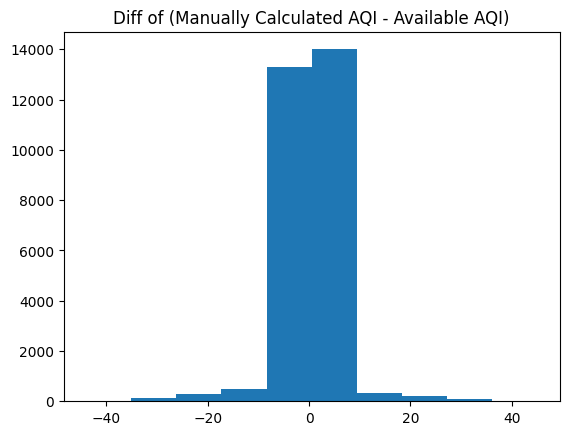

In [33]:
# Check stats cột diff nào:
diff = new_df['calc_diff']
diff_filtered = diff.dropna().astype(float)

print("Total rows:", diff.size)
print("Null count:", diff.isna().sum())
print()

print(diff_filtered.describe())
print()

plt.hist(diff_filtered, bins=10)
plt.title("Diff of (Manually Calculated AQI - Available AQI)")
plt.show()

In [38]:
# Diff nhỏ, phần lớn ±1 but we could do better. Introducing NowCast
def calc_aqi_nowcast(input_df):
    df = input_df.copy()
    
    # Sort by time for rolling calculations
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    
    # Rolling Averages (US EPA Standard) - so2 and no2 use hourly value
    df['pm25_nowcast'] = df['pm25'].rolling(window=12).apply(calc_nowcast_conc, raw=True)
    df['pm10_24h'] = df['pm10'].rolling(window=24).mean()
    df['o3_8h']    = df['o3'].rolling(window=8).mean()
    df['co_8h']    = df['co'].rolling(window=8).mean()
    
    # Unit Conversions (μg/m³ -> ppb/ppm) - pm25 and pm10 need no conversion
    df['co_8h_ppm'] = (df['co_8h'] * 24.45) / (28.01 * 1000) 
    df['no2_1h_ppb'] = (df['no2'] * 24.45) / 46.01
    df['so2_1h_ppb'] = (df['so2'] * 24.45) / 64.06
    df['o3_8h_ppb']  = (df['o3_8h'] * 24.45) / 48.00
    
    # Breakdance - same as before
    breakpoints_us = {
        'pm25': [(0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150), (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300), (250.5, 500.4, 301, 500)],
        'pm10': [(0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150), (255, 354, 151, 200), (355, 424, 201, 300), (425, 604, 301, 500)],
        'o3':   [(0, 54, 0, 50), (55, 70, 51, 100), (71, 85, 101, 150), (86, 105, 151, 200), (106, 200, 201, 300)],
        'no2':  [(0, 53, 0, 50), (54, 100, 51, 100), (101, 360, 101, 150), (361, 649, 151, 200), (650, 1249, 201, 300)],
        'so2':  [(0, 35, 0, 50), (36, 75, 51, 100), (76, 185, 101, 150), (186, 304, 151, 200)],
        'co':   [(0.0, 4.4, 0, 50), (4.5, 9.4, 51, 100), (9.5, 12.4, 101, 150), (12.5, 15.4, 151, 200)]
    }

    # Calcium
    df['calc_pm25_aqi_nowcast'] = df['pm25_nowcast'].apply(lambda x: calc_piecewise(math.floor(x*10)/10 if pd.notnull(x) else x, breakpoints_us['pm25']))
    df['calc_pm10_aqi'] = df['pm10_24h'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['pm10']))
    df['calc_o3_aqi']   = df['o3_8h_ppb'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['o3']))
    df['calc_no2_aqi']  = df['no2_1h_ppb'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['no2']))
    df['calc_so2_aqi']  = df['so2_1h_ppb'].apply(lambda x: calc_piecewise(math.floor(x) if pd.notnull(x) else x, breakpoints_us['so2']))
    df['calc_co_aqi']   = df['co_8h_ppm'].apply(lambda x: calc_piecewise(math.floor(x*10)/10 if pd.notnull(x) else x, breakpoints_us['co']))
    
    # Overall AQI (Max of all pollutants)
    df['calc_aqi_nowcast'] = df[['calc_pm25_aqi_nowcast', 'calc_pm10_aqi', 'calc_o3_aqi', 'calc_no2_aqi', 'calc_so2_aqi', 'calc_co_aqi']].max(axis=1)

    # Comparison with existing column
    if 'aqi' in df.columns:
        df['calc_diff_nowcast'] = df['calc_aqi_nowcast'] - df['aqi']

    # --- 5. CLEANUP & SAVE ---
    
    # Columns to Drop (Intermediate calculations)
    cols_to_drop = [
        'pm25_nowcast', 'pm10_24h', 'o3_8h', 'co_8h', 
        'co_8h_ppm', 'no2_1h_ppb', 'so2_1h_ppb', 'o3_8h_ppb',
        'calc_pm25_aqi_nowcast', 'calc_pm10_aqi', 'calc_o3_aqi', 'calc_no2_aqi', 'calc_so2_aqi', 'calc_co_aqi'
    ]

    df_final = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    return df_final

Total rows: 28896
Null count: 31

count    28865.000000
mean        -2.815382
std         25.961152
min        -98.000000
25%        -18.000000
50%         -2.000000
75%         12.000000
max        137.000000
Name: calc_diff_nowcast, dtype: float64



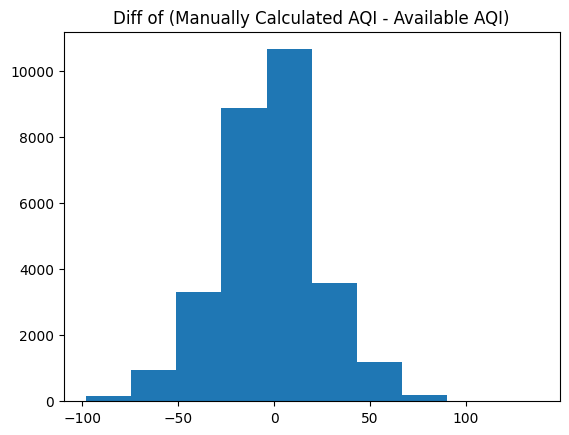

In [41]:
newer_df = calc_aqi_nowcast(df)
# Check stats cột diff nào:
diff = newer_df['calc_diff_nowcast']
diff_filtered = diff.dropna().astype(float)

print("Total rows:", diff.size)
print("Null count:", diff.isna().sum())
print()

print(diff_filtered.describe())
print()

plt.hist(diff_filtered, bins=10)
plt.title("Diff of (Manually Calculated AQI - Available AQI)")
plt.show()

NowCast không ổn r :))))) Thế chắc ae lại dùng công thức cơ bản `calc_aqi()` nếu muốn tính nhé

## EDA

TL;DR: Chắc có những cột `['temperature_2m', 'relative_humidity_2m', 'wind_direction_10m', 'wind_speed_10m', 'is_raining', 'hour', 'month', 'day_of_week']` dùng đc để train.

In [119]:
df = pd.read_csv('data/hanoi_air_weather_enriched.csv')
print(df.columns)

Index(['time', 'temperature_2m', 'relative_humidity_2m', 'rain',
       'wind_direction_10m', 'wind_speed_10m', 'pm25', 'pm10', 'co', 'no2',
       'so2', 'o3', 'aqi', 'aqi_pm25', 'aqi_category', 'calc_aqi', 'calc_diff',
       'hour', 'month', 'day_of_week', 'is_weekend', 'is_raining',
       'temperature_2m_lag1', 'relative_humidity_2m_lag1', 'rain_lag1',
       'wind_speed_10m_lag1'],
      dtype='object')


In [75]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Temporal features
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month_name()
df['day_of_week'] = df['time'].dt.day_name()
df['is_weekend'] = df['time'].dt.dayofweek >= 5

# Define custom order for categorical plots
day_order = list(calendar.day_name)
aqi_order = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
month_order = list(calendar.month_name)[1:]

print(day_order, month_order)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [76]:
df.to_csv('data/hanoi_air_weather_enriched.csv', index=False)


Percentage of hours in each category:
Good: 1.0%
Moderate: 37.1%
Unhealthy for Sensitive Groups: 36.3%
Unhealthy: 24.2%
Very Unhealthy: 1.3%


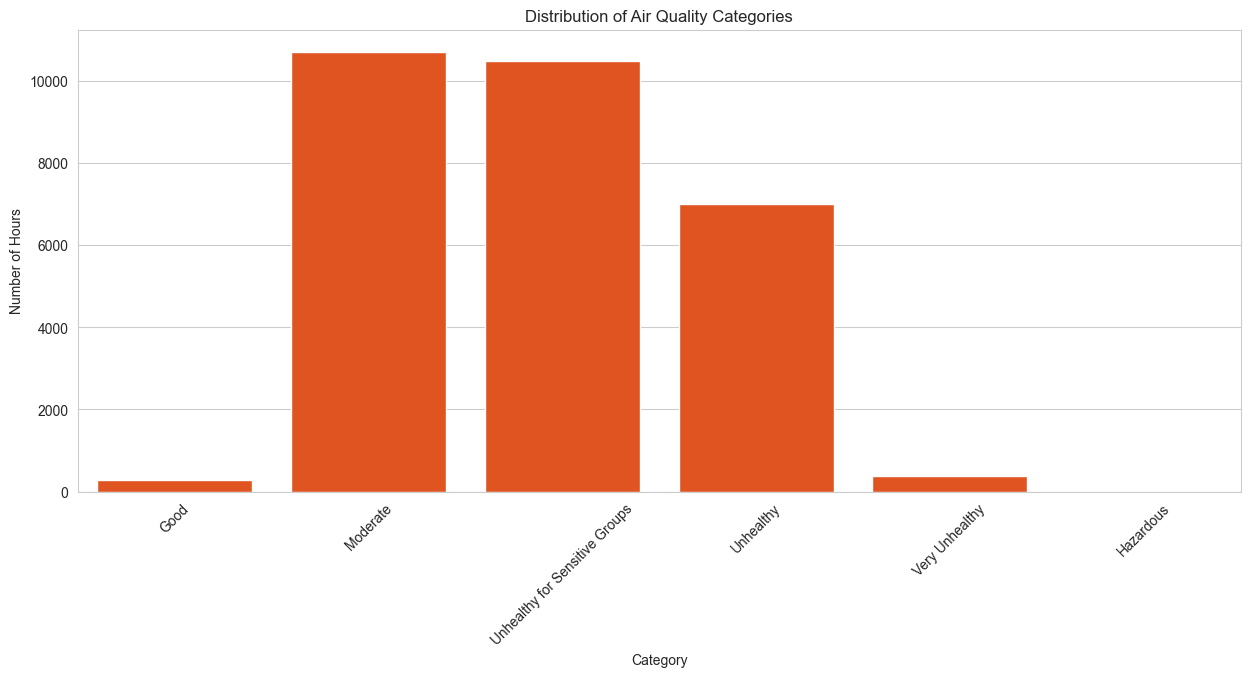

In [118]:
plt.figure(figsize=(15, 6))

# Countplot of AQI Categories
sns.countplot(data=df, x='aqi_category', order=aqi_order, color='orangered')

plt.title('Distribution of Air Quality Categories')
plt.xticks(rotation=45)
plt.ylabel('Number of Hours')
plt.xlabel('Category')

# Calculate percentages
total = len(df)
counts = df['aqi_category'].value_counts()
print("\nPercentage of hours in each category:")
for cat in aqi_order:
    if cat in counts:
        print(f"{cat}: {counts[cat]/total*100:.1f}%")

plt.show()

Trộm vía không có Hazardous, với Good và Very Unhealthy là borderline rare (>1.0%). Cần SMOTE hay class weighting hay gì k ae?

### Temporal features

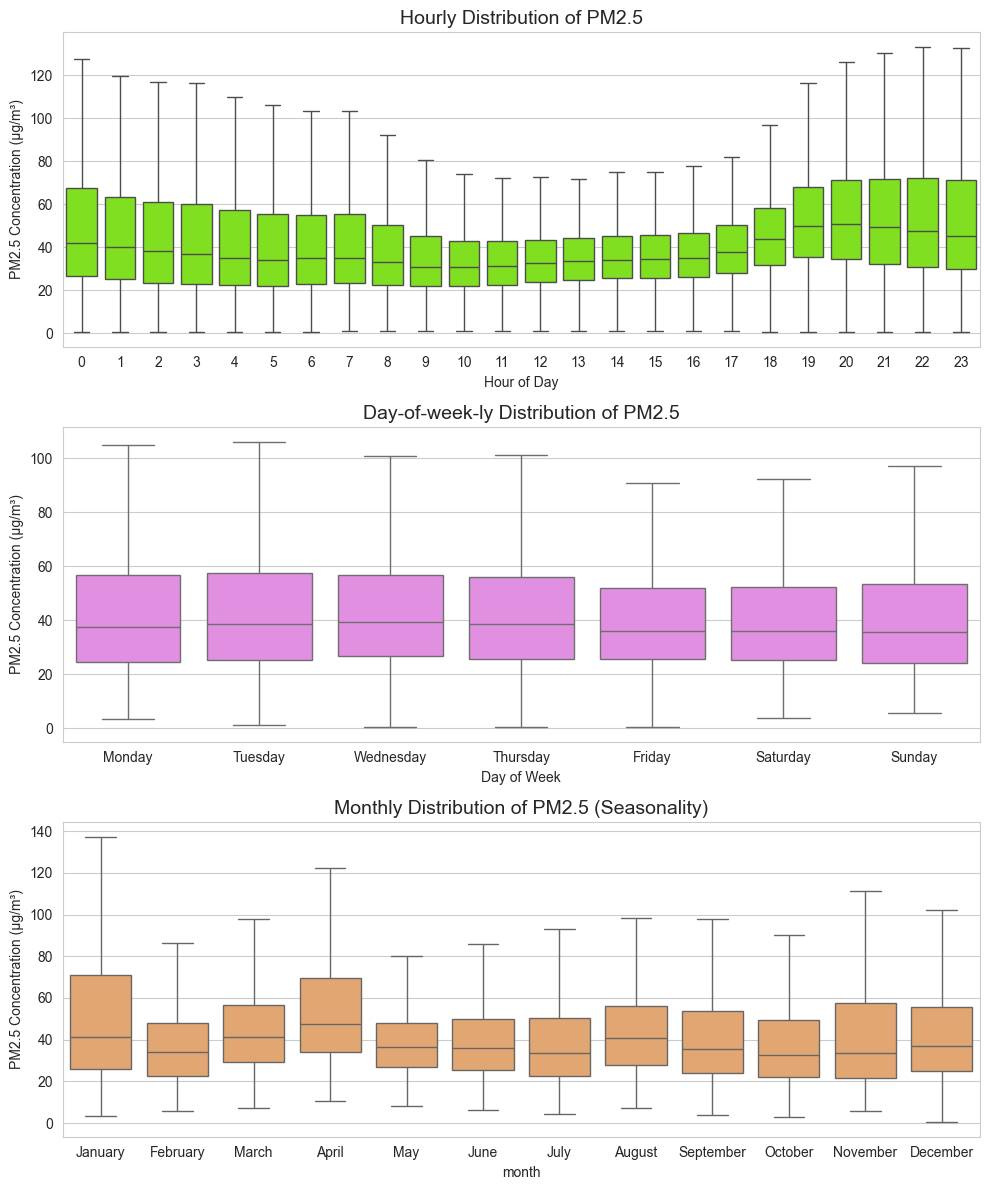

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# PM2.5 Distribution by Hour
sns.boxplot(data=df, x='hour', y='pm25', ax=axes[0], color='chartreuse', showfliers=False)
axes[0].set_title('Hourly Distribution of PM2.5', fontsize=14)
axes[0].set_ylabel('PM2.5 Concentration (µg/m³)')
axes[0].set_xlabel('Hour of Day')

# PM2.5 Distribution by Day of Week
sns.boxplot(data=df, x='day_of_week', y='pm25', order=day_order, ax=axes[1], color='violet', showfliers=False)
axes[1].set_title('Day-of-week-ly Distribution of PM2.5', fontsize=14)
axes[1].set_ylabel('PM2.5 Concentration (µg/m³)')
axes[1].set_xlabel('Day of Week')

# PM2.5 Distribution by Month
sns.boxplot(data=df, x='month', y='pm25', order=month_order, ax=axes[2], color='sandybrown', showfliers=False)
axes[2].set_title('Monthly Distribution of PM2.5 (Seasonality)', fontsize=14)
axes[2].set_ylabel('PM2.5 Concentration (µg/m³)')

plt.tight_layout()
plt.show()

U-shaped pattern for Hour of Day. Why? Just my speculation:
- AM and PM rushes around 6 and 17 *supposedly* raise PM2.5 concentration. Not really evident at AM, but more noticeable at PM.
- Noon and early afternoon: Sun warms the air and disperses pollutant, traffic eases.
- Night: temperature drop - trapped air, little decline.

But whether it's warm or wet or not, much depends on the season. The monthly distribution says nothing, there's little variance between days of the week.

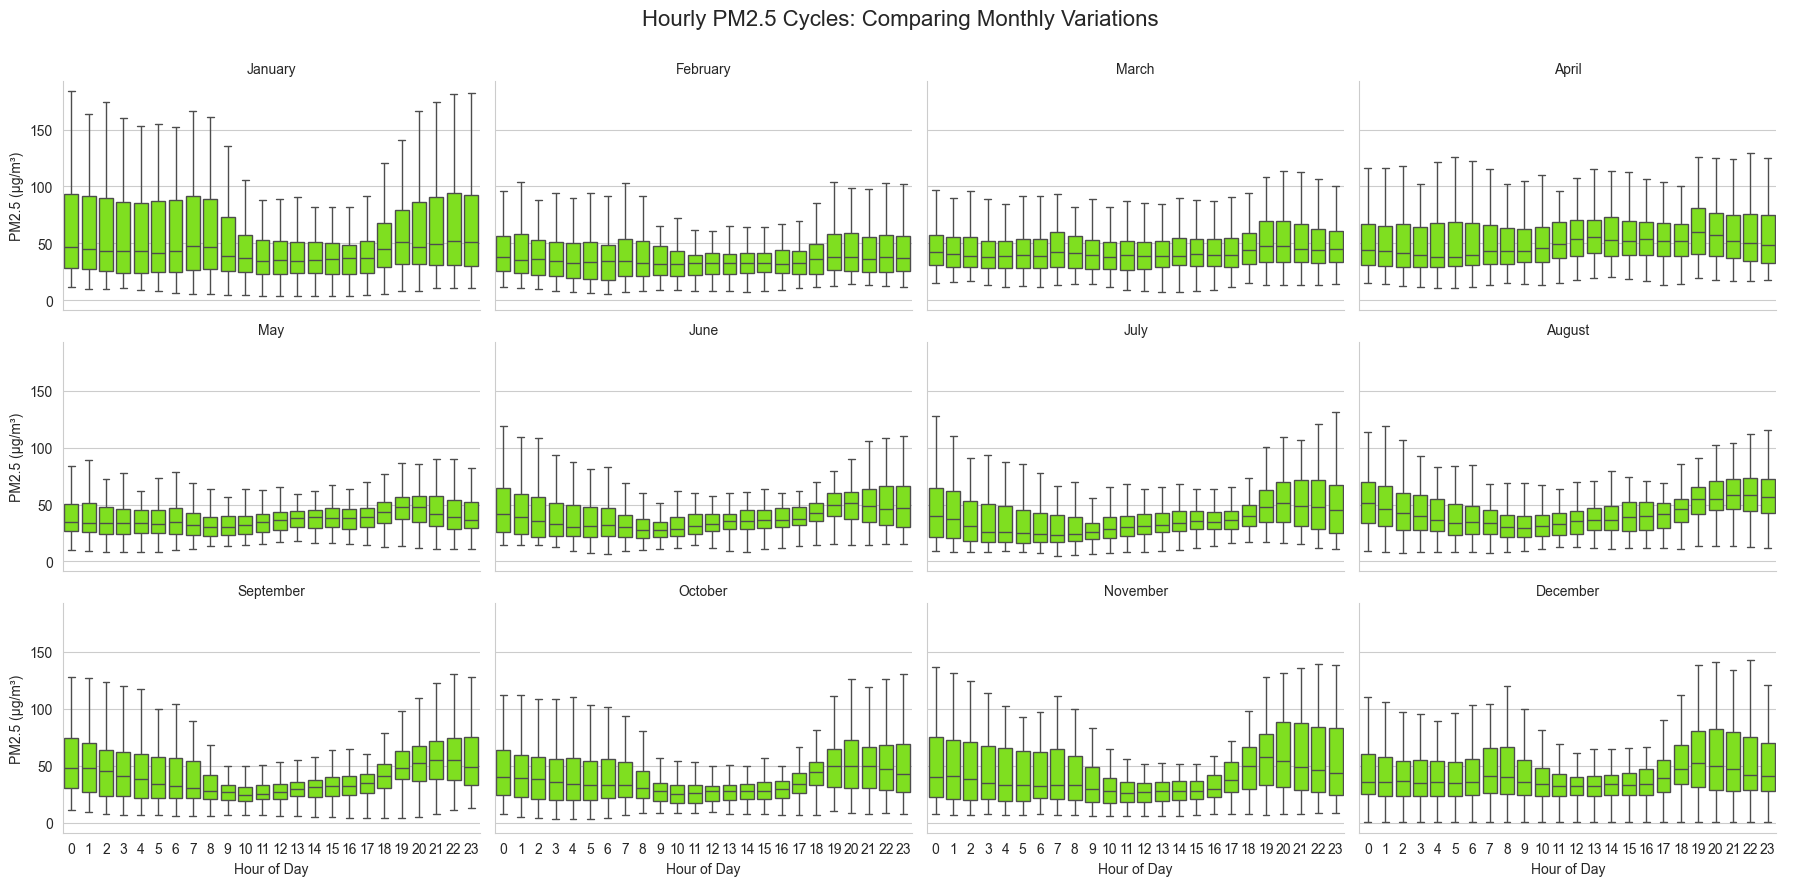

In [ ]:
g = sns.catplot(
    data=df,
    x='hour',
    y='pm25',
    col='month',
    col_order=month_order,
    col_wrap=4,
    kind='box',
    color='chartreuse',
    showfliers=False,
    height=3,
    aspect=1.5
)

g.set_titles("{col_name}")
g.set_axis_labels("Hour of Day", "PM2.5 (µg/m³)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Hourly PM2.5 Cycles: Comparing Monthly Variations', fontsize=16)

plt.show()

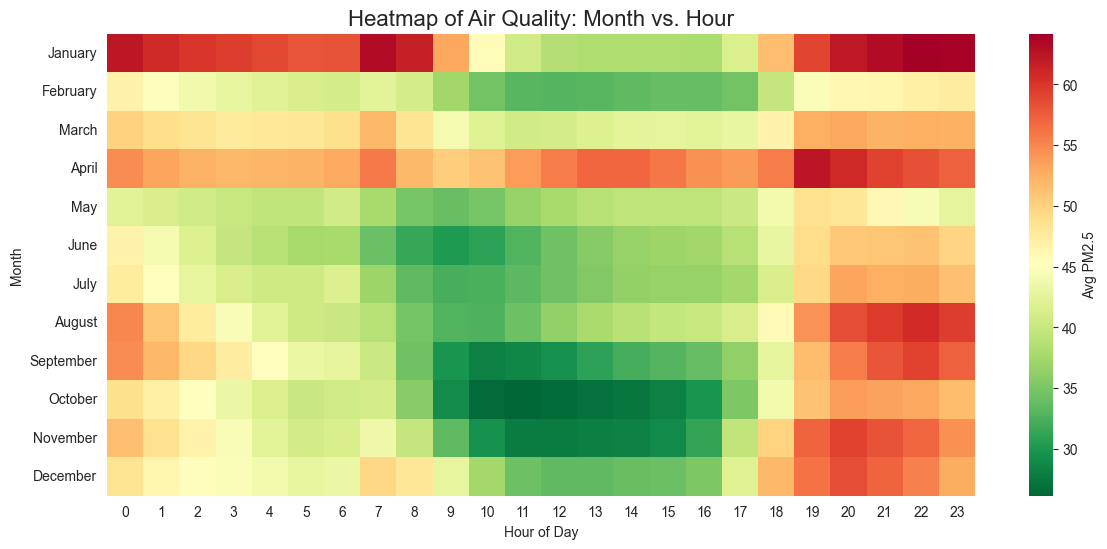

In [88]:
pivot_table = df.pivot_table(values='pm25', index='month', columns='hour', aggfunc='mean')
pivot_table = pivot_table.reindex(month_order)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='RdYlGn_r', annot=False, cbar_kws={'label': 'Avg PM2.5'})
plt.title('Heatmap of Air Quality: Month vs. Hour', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.yticks(rotation=0) 
plt.show()

Hell yeah! The U-shape is much more pronounced during not-so-warm seasons and flattens during summer months.

**Conclusion:** PM2.5 does vary with Hour of Day depending on the season. Summer observes low value and low variance of concentration.

In [ ]:
df.to_csv('data/hanoi_air_weather_enriched.csv', index=False)

### Weather features

In [102]:
cols = ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'wind_speed_10m', 'no2', 'so2', 'co', 'o3']
print(df[cols].describe())

       temperature_2m  relative_humidity_2m  precipitation          rain  \
count    28896.000000          28896.000000   28896.000000  28896.000000   
mean        24.515248             79.157530       0.274737      0.274737   
std          5.397653             14.664587       1.143835      1.143835   
min          6.500000             22.000000       0.000000      0.000000   
25%         21.000000             70.000000       0.000000      0.000000   
50%         25.400000             82.000000       0.000000      0.000000   
75%         28.200000             91.000000       0.100000      0.100000   
max         41.100000            100.000000      26.400000     26.400000   

       wind_speed_10m           no2           so2            co            o3  
count    28896.000000  28889.000000  28889.000000  28889.000000  28889.000000  
mean         8.852270     26.768317     25.288082    703.655855     73.806362  
std          4.507867     20.467011     12.410042    459.277587     54.6126

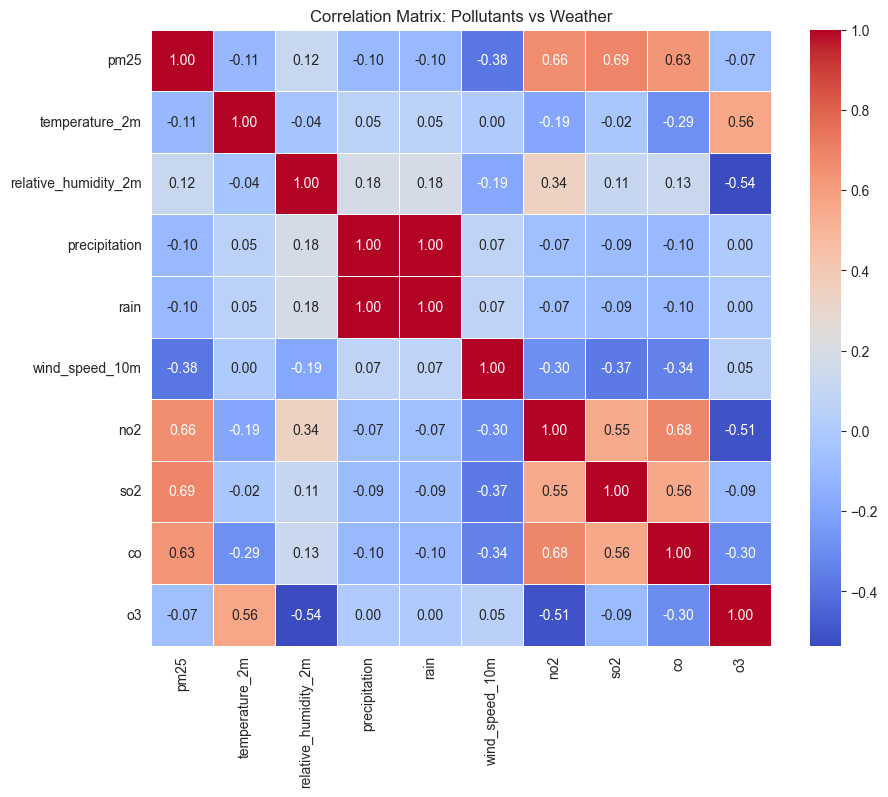

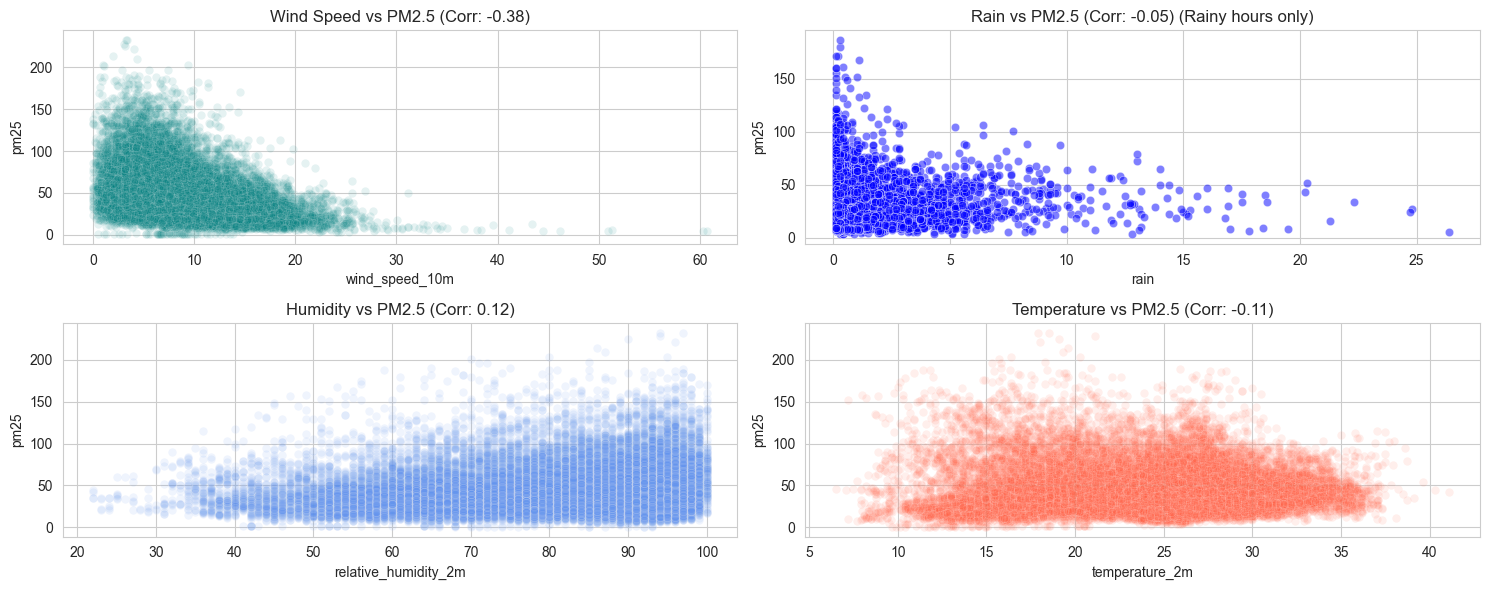

In [98]:
cols = ['pm25', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'wind_speed_10m', 'no2', 'so2', 'co', 'o3']
corr_matrix = df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Pollutants vs Weather')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 6))
axes_flat = axes.ravel()

# Wind speed vs PM2.5
wind_corr = df['wind_speed_10m'].corr(df['pm25'])
sns.scatterplot(data=df, x='wind_speed_10m', y='pm25', alpha=0.1, ax=axes_flat[0], color='teal')
axes_flat[0].set_title(f"Wind Speed vs PM2.5 (Corr: {wind_corr:.2f})")

# Rain vs PM2.5 (rainy hours only)
rain_df = df[df['rain'] > 0]
rain_corr = rain_df['rain'].corr(rain_df['pm25'])
sns.scatterplot(data=rain_df, x='rain', y='pm25', alpha=0.5, ax=axes_flat[1], color='blue')
axes_flat[1].set_title(f"Rain vs PM2.5 (Corr: {rain_corr:.2f}) (Rainy hours only)")

# Humidity vs PM2.5
hum_corr = df['relative_humidity_2m'].corr(df['pm25'])
sns.scatterplot(data=df, x='relative_humidity_2m', y='pm25', alpha=0.1, ax=axes_flat[2], color='cornflowerblue')
axes_flat[2].set_title(f"Humidity vs PM2.5 (Corr: {hum_corr:.2f})")

# Temperature vs PM2.5
temp_corr = df['temperature_2m'].corr(df['pm25'])
sns.scatterplot(data=df, x='temperature_2m', y='pm25', alpha=0.1, ax=axes_flat[3], color='tomato')
axes_flat[3].set_title(f"Temperature vs PM2.5 (Corr: {temp_corr:.2f})")

plt.tight_layout()
plt.show()

Observations:
- Rain == Precipitation. I mean yeah sure why won't they? Why does the API even separate them lol -> Will drop one.
- Wind speed nicely negatively correlated with PM2.5 -> Core feature.
- Correlation plot with Rain is quite sparse: Most data points have rain = 0.0. Those with positive values are not large enough in value and quantity to make real difference. -> Add boolean feature `is_raining`, hope it does something.
- MAYBE "lag" effect of weather: rain, wind, humidity, etc. takes some time (e.g. 1h) to reduce/raise pollutant conc. -> Create lag features, re-plot.

In [107]:
df.drop(columns=['precipitation'], inplace=True)
df['is_raining'] = df['rain'] > 0

lag_cols = ['temperature_2m', 'relative_humidity_2m', 'rain', 'wind_speed_10m']
for c in lag_cols:
    df[f'{c}_lag1'] = df[c].shift(1)

print(df.columns)

Index(['time', 'temperature_2m', 'relative_humidity_2m', 'rain',
       'wind_direction_10m', 'wind_speed_10m', 'pm25', 'pm10', 'co', 'no2',
       'so2', 'o3', 'aqi', 'aqi_pm25', 'aqi_category', 'calc_aqi', 'calc_diff',
       'hour', 'month', 'day_of_week', 'is_weekend', 'is_raining',
       'temperature_2m_lag1', 'relative_humidity_2m_lag1', 'rain_lag1',
       'wind_speed_10m_lag1'],
      dtype='object')


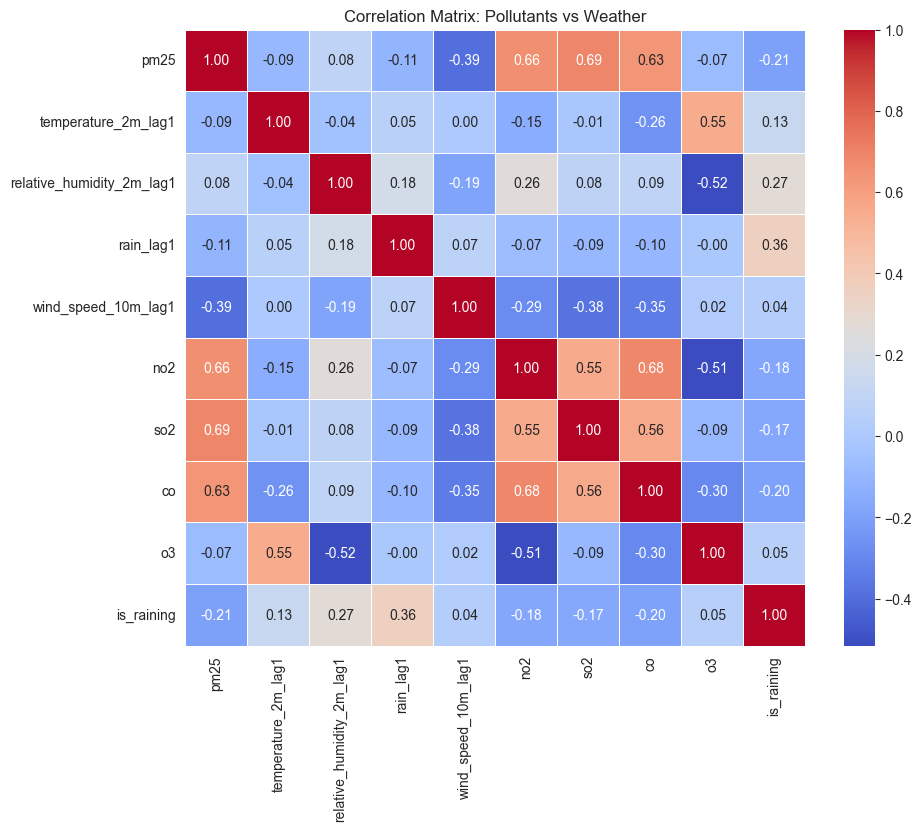

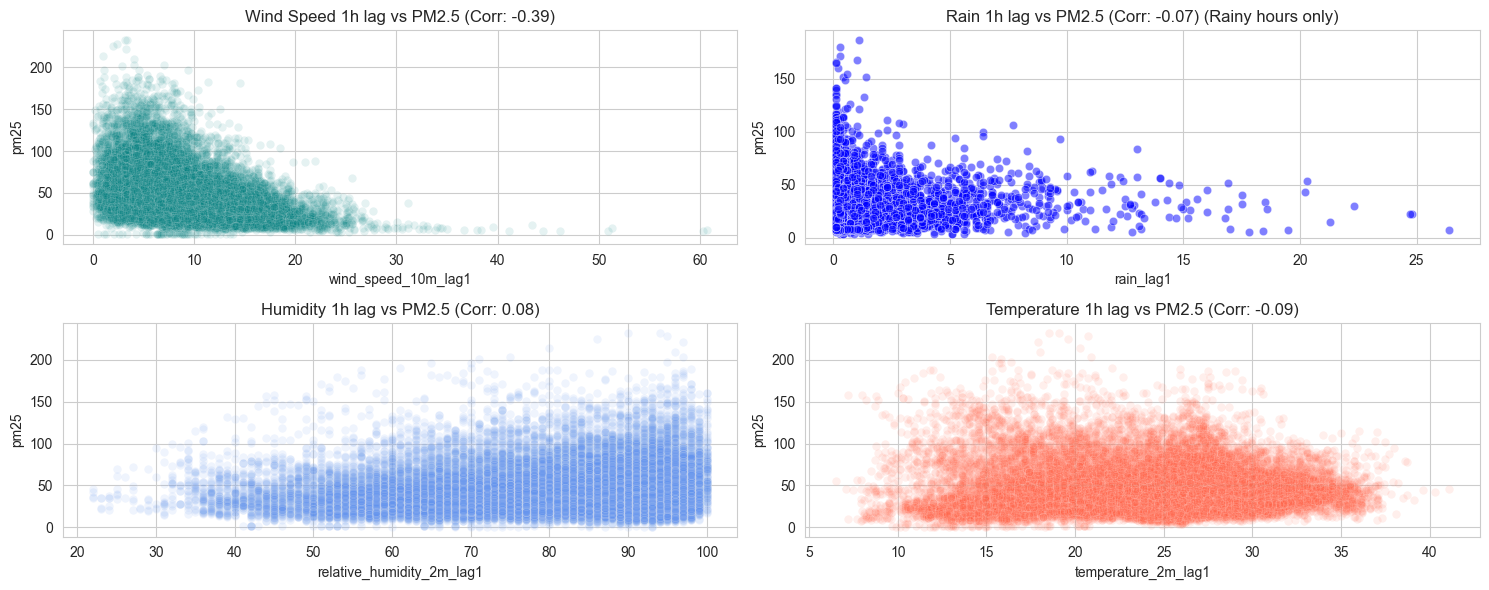

In [120]:
cols = ['pm25', 'temperature_2m_lag1', 'relative_humidity_2m_lag1', 'rain_lag1', 'wind_speed_10m_lag1', 'no2', 'so2', 'co', 'o3', 'is_raining']
corr_matrix = df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Pollutants vs Weather')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 6))
axes_flat = axes.ravel()

# Wind speed vs PM2.5
wind_corr = df['wind_speed_10m_lag1'].corr(df['pm25'])
sns.scatterplot(data=df, x='wind_speed_10m_lag1', y='pm25', alpha=0.1, ax=axes_flat[0], color='teal')
axes_flat[0].set_title(f"Wind Speed 1h lag vs PM2.5 (Corr: {wind_corr:.2f})")

# Rain vs PM2.5 (rainy hours only)
rain_df = df[df['rain_lag1'] > 0]
rain_corr = rain_df['rain_lag1'].corr(rain_df['pm25'])
sns.scatterplot(data=rain_df, x='rain_lag1', y='pm25', alpha=0.5, ax=axes_flat[1], color='blue')
axes_flat[1].set_title(f"Rain 1h lag vs PM2.5 (Corr: {rain_corr:.2f}) (Rainy hours only)")

# Humidity vs PM2.5
hum_corr = df['relative_humidity_2m_lag1'].corr(df['pm25'])
sns.scatterplot(data=df, x='relative_humidity_2m_lag1', y='pm25', alpha=0.1, ax=axes_flat[2], color='cornflowerblue')
axes_flat[2].set_title(f"Humidity 1h lag vs PM2.5 (Corr: {hum_corr:.2f})")

# Temperature vs PM2.5
temp_corr = df['temperature_2m_lag1'].corr(df['pm25'])
sns.scatterplot(data=df, x='temperature_2m_lag1', y='pm25', alpha=0.1, ax=axes_flat[3], color='tomato')
axes_flat[3].set_title(f"Temperature 1h lag vs PM2.5 (Corr: {temp_corr:.2f})")

plt.tight_layout()
plt.show()

Not as dramatic as I thought... Just use whatever version of features you like, with or without lag. ONLY 1 THO, like don't put both `rain_lag1` and `rain` into training.

In [110]:
df.to_csv('data/hanoi_air_weather_enriched.csv', index=False)

### Wind direction feature???

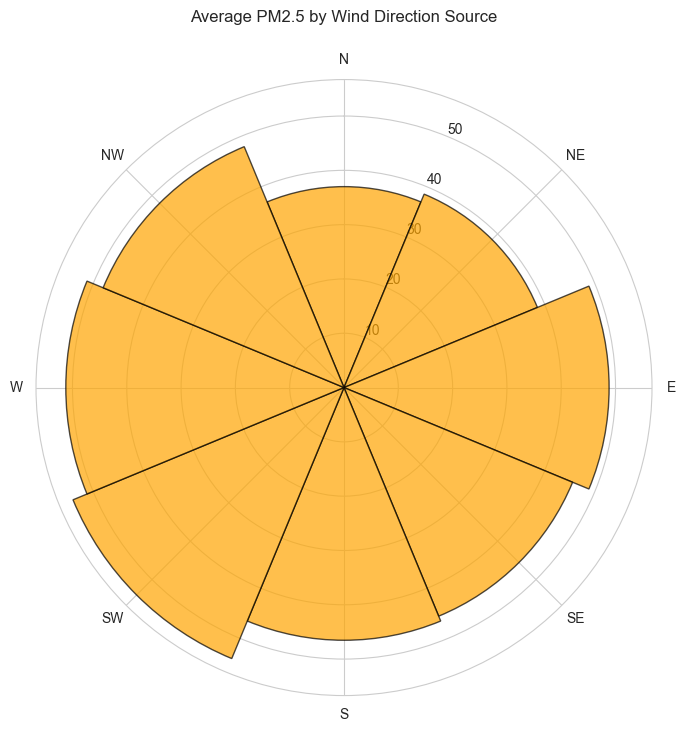

In [112]:
# Bin wind direction into 8 sectors (N, NE, E, SE, S, SW, W, NW)
def wind_direction_to_sector(d):
    dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    ix = round(d / (360. / 8))
    return dirs[ix % 8]

df['wind_sector'] = df['wind_direction_10m'].apply(wind_direction_to_sector)

# Calculate mean PM2.5 per sector
sector_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
sector_avg = df.groupby('wind_sector')['pm25'].mean().reindex(sector_order)

# Polar Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
theta = np.linspace(0.0, 2 * np.pi, len(sector_avg), endpoint=False)
width = (2*np.pi) / len(sector_avg)

# Rotate so North is at the top (standard map convention)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

bars = ax.bar(theta, sector_avg, width=width, bottom=0.0, color='orange', alpha=0.7, edgecolor='black')

ax.set_xticks(theta)
ax.set_xticklabels(sector_order)
plt.title("Average PM2.5 by Wind Direction Source", y=1.08)
plt.show()

Suddenly it's Địa Lý all over again, gió mùa Tây Nam mang theo hơi ẩm và mưa lớn gây mưa to giông bão etc. Got no commment for now.